In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io as io
import cv2

In [2]:
# Directories containing images
dataDir = 'images'
annDir = 'val'
fileLabel = 'ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt'
fileLabelNames = 'labelNames.txt'
fileImageNetNames = 'ImageNetLabels.txt'

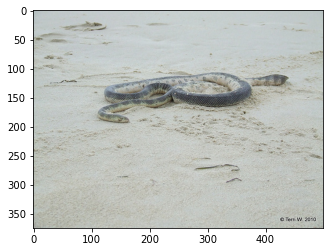

In [3]:
fileName = 'ILSVRC2012_val_00000001.JPEG'
I = io.imread( '%s/%s'%(dataDir,fileName) )
plt.imshow(I)
plt.show()

In [4]:
IMG_SIZE = [ 227, 227 ]
image = I
image = tf.image.resize( image, IMG_SIZE )
image /= 255

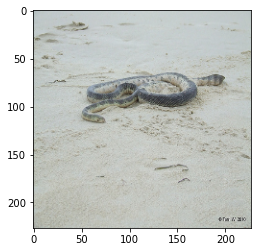

In [5]:
plt.imshow(image)
plt.show()

In [275]:
def gaussianPyramid( image, sig_o ):

    pyramid = [ image ]
    sig = sig_o
    while tf.shape( image )[0] > 1:

        image = applyGauss( image, sig )
        pyramid.append( tf.image.resize( image, IMG_SIZE ) )    # Resize image to size of original
        sig = 2*sig

    return pyramid

def applyGauss( image, sig ):

    # Apply Gaussian blur
    ksize = (0,0)   # Kernel size is computed from sig values
    sigX = sig
    sigY = 0        # sigY uses sigX
    image = cv2.GaussianBlur( image, ksize, sigX, sigY )

    # Downsample
    height, width, _ = tf.shape( image )
    image = cv2.pyrDown(image, dstsize=(height // 2, width // 2))

    return image


def laplacianPyramid( gaussPyramid ):

    pyramid = []

    # Calculate the difference between each layer
    for i in range( len(gaussPyramid)-1 ): 
        pyramid.append( abs(gaussPyramid[i] - gaussPyramid[i+1]) )
    
    # Append the last layer to the top of the pyramid
    pyramid.append( gaussPyramid[-1] )  

    return pyramid

In [276]:
# Reset image
IMG_SIZE = [ 227, 227 ]
image = I
image = tf.image.resize( image, IMG_SIZE )
image /= 255

# Test Gaussian blurring
sig_o = 1   # Defined in the paper
gaussPyramid = gaussianPyramid( image, sig_o )
print( "Gauss:", len( gaussPyramid ) )
plt.imshow( gaussPyramid[2] )
plt.show()

# Test Laplacian
laplacePyramid = laplacianPyramid( gaussPyramid )
print( "Laplace:", len(laplacePyramid) )
plt.imshow( laplacePyramid[0] )
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'src'

tf.Tensor([  8 227 227   1], shape=(4,), dtype=int32)
tf.Tensor([  8 227 227   3], shape=(4,), dtype=int32)
tf.Tensor([227 227   3], shape=(3,), dtype=int32)


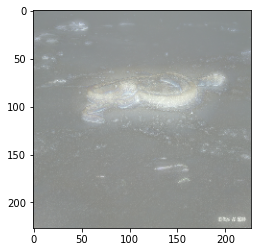

In [270]:
def expWeight( laplacePyramid, u_o, v_o, f_o ):

    # Ensure center is an int
    u_o = tf.cast( np.ceil(u_o), tf.int32 )
    v_o = tf.cast( np.ceil(v_o), tf.int32 )

    # Generate coordinates centered at u_o, v_o
    height, width, _ = tf.shape( laplacePyramid[0] )
    u_front = tf.reverse( tf.range( 1, u_o ), axis=[-1] )
    u_back = tf.range( height-u_o+1 )
    v_front = tf.reverse( tf.range( 1, v_o ), axis=[-1] )
    v_back = tf.range( width-v_o+1 )
    u = tf.concat( [ u_front, u_back ], axis=-1 )
    v = tf.concat( [ v_front, v_back ], axis=-1 )

    # Create a matrix of coordinates
    v = np.expand_dims( v, axis=-1 )            # For broadcasting
    coords = tf.math.pow(u,2) + tf.math.pow(v,2)
    coords = np.expand_dims( coords, axis=0 )   # For broadcasting

    # Create the foveal size for each level
    k = tf.range( len(laplacePyramid) )
    f_k = tf.math.pow(2,k) * f_o
    f_k = np.expand_dims( np.expand_dims( f_k, axis=-1 ), axis=-1 )

    # Get the kernel needed to multiply the pyramid
    kernel = tf.exp( -coords / ( 2*tf.math.pow(f_k,2) ) )
    kernel = np.expand_dims( kernel, axis=-1 )  # For broadcasting
    print( tf.shape(kernel) )
    laplacePyramid = tf.convert_to_tensor( laplacePyramid )
    print( tf.shape(laplacePyramid))
    pyramid = laplacePyramid * kernel 

    return pyramid

height, width, _ = tf.shape( laplacePyramid[0] )
pyramid = expWeight( laplacePyramid, height/2, width/2, 70 )
pyramid = tf.reduce_sum( pyramid, axis=0 )
print( tf.shape(pyramid) )
#plt.imshow( pyramid )
plt.imshow( pyramid/np.max(pyramid) )
plt.show()

In [249]:
def laplacianPyramid( image, sig_o ):

    pyramid = []
    sig = sig_o
    for _ in range(3):

        prevImage = image
        image = applyGauss( image, sig )
        pyramid.append( abs( prevImage - image ) )

        # Downsample
        height, width, _ = tf.shape( image )
        newHeight = tf.math.floor( height/2 )
        newWidth = tf.math.floor( width/2 )
        image = tf.image.resize( image, [ newHeight, newWidth ] )

        sig = 2*sig

    pyramid.append( image )
    return pyramid

def applyGauss( image, sig ):

    # Apply Gaussian blur
    ksize = (0,0)   # Kernel size is computed from sig values
    sigX = sig
    sigY = 0        # sigY uses sigX
    image = cv2.GaussianBlur( image.numpy(), ksize, sigX, sigY )

    return image

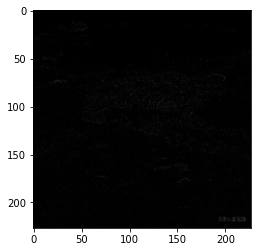

In [250]:
IMG_SIZE = [ 227, 227 ]
image = I
image = tf.image.resize( image, IMG_SIZE )
image /= 255

laplacePyramid = laplacianPyramid( image, 0.5 )
plt.imshow( laplacePyramid[0] )
plt.show()

tf.Tensor([227 227   1], shape=(3,), dtype=int32)
tf.Tensor([113 113   1], shape=(3,), dtype=int32)
tf.Tensor([56 56  1], shape=(3,), dtype=int32)
Pyramid: tf.Tensor([227 227   3], shape=(3,), dtype=int32)


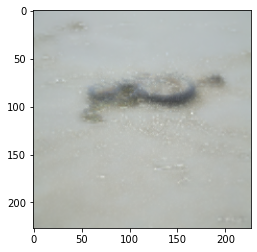

In [251]:
def expWeight( laplacePyramid, u_o, v_o, f_o ):

    # Ensure center is an int
    u_o = tf.cast( np.ceil(u_o), tf.int32 )
    v_o = tf.cast( np.ceil(v_o), tf.int32 )

    # Get ratios to use for each level
    height, width, _ = tf.shape( laplacePyramid[0] )
    u_o = tf.cast( u_o/height, tf.float32 )
    v_o = tf.cast( v_o/width, tf.float32 )

    pyramid = []

    for k in range( len(laplacePyramid) ):

        height, width, _ = tf.shape( laplacePyramid[k] )
        height = tf.cast( height, tf.float32 )
        width = tf.cast( width, tf.float32 )

        # Ensure center is an int
        u_cur = np.ceil(u_o * height)
        v_cur = np.ceil(v_o * width)

        # Generate coordinates centered at (u_o, v_o) for each level
        u_front = tf.reverse( tf.range( 1, u_cur ), axis=[-1] )
        u_back = tf.range( height-u_cur+1 )
        v_front = tf.reverse( tf.range( 1, v_cur ), axis=[-1] )
        v_back = tf.range( width-v_cur+1 )
        u = tf.concat( [ u_front, u_back ], axis=-1 )
        v = tf.concat( [ v_front, v_back ], axis=-1 )

        # Create a matrix of coordinates
        v = np.expand_dims( v, axis=-1 )            # For broadcasting
        coords = tf.math.pow(u,2) + tf.math.pow(v,2)

        # Create the foveal size for each level
        f_k = tf.math.pow(2,k) * f_o
        f_k = np.expand_dims( np.expand_dims( f_k, axis=-1 ), axis=-1 )
        f_k = tf.cast( f_k, tf.float32 )

        # Get the kernel needed to multiply the pyramid
        kernel = tf.exp( -coords / ( 2*tf.math.pow(f_k,2) ) )
        kernel = np.expand_dims( kernel, axis=-1 )  # For broadcasting
        print( tf.shape(kernel) )
        pyramid.append( laplacePyramid[k] * kernel )

    return pyramid

height, width, _ = tf.shape( laplacePyramid[0] )
pyramid = expWeight( laplacePyramid, height/2, width/2, 70 )

# Upsample
finalImg = pyramid[-1]
for i in reversed( range( len(pyramid)-1 ) ):
    
    height, width, _ = tf.shape( pyramid[i] )
    finalImg = tf.image.resize( finalImg, [height,width] ) + pyramid[i]

# Test Laplace
# finalImg = laplacePyramid[-1]
# for i in reversed( range( len(laplacePyramid)-1 ) ):
    
#     height, width, _ = tf.shape( laplacePyramid[i] )
#     finalImg = tf.image.resize( finalImg, [height,width] ) + laplacePyramid[i]

#pyramid = tf.reduce_sum( pyramid, axis=0 )
print( "Pyramid:", tf.shape(finalImg) )
#plt.imshow( pyramid )
plt.imshow( finalImg/np.max(finalImg) )
plt.show()

In [ ]:

src = cv.pyrUp(src, dstsize=(2 * cols, 2 * rows))